In [11]:
#use this notebook to determine the optimal number of K means groups for the dataset
#there are three options
#KL 12 April 2016

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#this sets the stage to figure out the optimal number of K means groups
filename = 'nClustersRequired.py'
%run $filename

In [ ]:
##the data file read into the next cell was created as follows:
##(in main iPython notebook)
#dataFilename = 'NB_combined_for_kmeans.csv'
#Combined_KO_CO_final.to_csv(dataFilename)

In [7]:
dataFilename = 'NB_combined_for_kmeans.csv'
data = Data(dataFilename)
#pattern_labels are the rows...for us this will the RInumber
pattern_labels = []
patterns_data, pattern_labels = data.load_data()

In [8]:
def forest_run(dimensions, patterns, pattern_labels, metric='qe', fNamePrefix = '', k_up=20, k_down=2, simulations=55, iterations=50):
    """
    A method for watching Forest Gump run
    :param dimensions: the dimensionality of the data
    :param patterns: the data itself
    :param metric: the quality metric
    :fNamePrefix: put text in here if I want to add a unique prefix to the data file spit out at end
    :param k_up: the maximum number of clusters
    :param k_down: the minimum number of clusters
    :param simulations: the number of simulations for each k
    :param iterations: the number of iterations for each k-means pass
    """
    # variable to store the best result
    best_clustering = None
    # the quality of that result
    best_quality = 1000.00
    # write results out to file while simulating
    file_out = fNamePrefix + 'MonteCarloFinalResults' + '_' + metric + '.csv'
    #with open(file_out, 'w', newline='') as f: #newline doesn't work here
    with open(file_out,'w') as f:
        # different k values to test on
        for i in range(k_down, k_up):
            num_clusters = i
            # number of retries / simulations
            print('working on ' , i, '# of kmeans groups') #works, but doesn't look as I intended.
            
            for j in range(simulations):
                # create a clustering solution and apply k-means
                clustering = Clustering(dimensions, num_clusters, patterns, 0.0001)
                clustering.k_means_clustering(iterations)
                # used to compute quality of the solution
                quality = ClusteringQuality(clustering, 0.0001)
                this_quality = 0.0
                if metric == 'qe':
                    this_quality = quality.quantization_error()
                if metric == 'si':
                    this_quality = quality.average_silhouette_index()
                if metric == 'db':
                    this_quality = quality.davies_bouldin()
                # update the best clustering
                if this_quality < best_quality:
                    best_quality = this_quality
                    best_clustering = clustering
                    #print("Updated best clustering") #comment out, clogging up display
                # write result to the file
                result = [num_clusters, this_quality]
                for x in result:
                    f.write(str(x))
                    f.write(",")
                f.write("\n")
                f.flush()


In [9]:
dimensions = 5 #this is a function of the data itself. In the NB data we have five sampling days.
setSimulations = 100
setIterations = 100 #this is the default from the Turing Finance code
setKup = 20
setKdown = 2

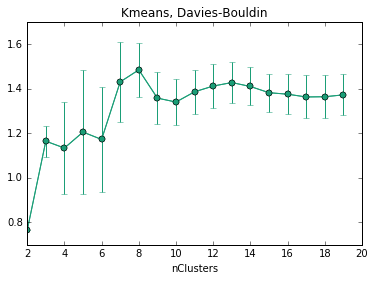

In [17]:
#first method to try is Davies-Bouldin index
prefix = 'newKO_norm2mean_'

#set the next line to true to actually run this
if False:   
    forest_run(dimensions, patterns_data, pattern_labels, metric='db', fNamePrefix = prefix,
           simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

#read in the results
riScores_db=pd.read_csv((prefix + 'MonteCarloFinalResults_db.csv'),header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])

#optimal cluster solution has the smallest Davies-Bouldin index
grouped = riScores_db.groupby('nClusters')
means = grouped.mean().unstack()
errors = grouped.std().unstack()
fig, ax = plt.subplots()
plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
plt.title('Kmeans, Davies-Bouldin')
ax.set_xlabel('nClusters')
plt.show() 
fig.savefig('DaviesBouldin_newKO.pdf')

In [ ]:
#next method is quantization error 
if False:
    prefix = 'newKO_norm2mean_'

    if False:
        forest_run(dimensions, patterns_data, pattern_labels, metric='qe', fNamePrefix = prefix,
               simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

    #now read in the results
    riScores_qe=pd.read_csv((prefix + 'MonteCarloFinalResults_qe.csv'),header=None,delimiter=',',
                    index_col=False,names=['nClusters', 'score'])

    grouped = riScores_qe.groupby('nClusters')
    means = grouped.mean().unstack()
    errors = grouped.std().unstack()
    fig, ax = plt.subplots()
    plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
    plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
    plt.title('Kmeans, Quantization error')
    ax.set_xlabel('nClusters')
    plt.show()

    #goal is to minimize quantization error. QE is the distance between a sample
    #and its representation. Lower quantization errors represent a good data cluster.

In [ ]:
#final method is silhouette error
if False: ##silhouette is really slow cfd to the other
    prefix = 'newKO_norm2mean_'

    # #silhouette is quite slow cfd to the other two metrics
    if False:
        forest_run(dimensions, patterns_data, pattern_labels, metric='si', fNamePrefix = prefix,
               simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

    riScores_si=pd.read_csv((prefix + 'MonteCarloFinalResults_si.csv'),header=None,delimiter=',',
                    index_col=False,names=['nClusters', 'score'])


    ##note, want to maximize the silhouette value for each pattern in the dataset
    grouped = riScores_si.groupby('nClusters')
    means = grouped.mean().unstack()
    errors = grouped.std().unstack()
    fig, ax = plt.subplots()
    plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
    plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
    plt.title('Kmeans, silhouette index')
    ax.set_xlabel('nClusters')
    plt.show()

    #remember, want to maximize this value